In [570]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv
import skimage
from skimage import data, io, filters, exposure
from skimage.color import rgb2gray
from skimage import feature
from skimage import measure
import random as rng

from dice_counter import *

In [571]:
def process_image(image):
    image = cv.resize(image, (800, 600))
    image_grayscale = cv.cvtColor(255 - image, cv.COLOR_RGB2GRAY)
    temp = remove_everything_above_std_and_mean(image_grayscale)
    contoured_image1 = draw_contours(temp)
    plt.figure(figsize=(25,25))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.subplot(1, 2, 2)
    plt.imshow(contoured_image1, cmap='gray')
    return contoured_image1

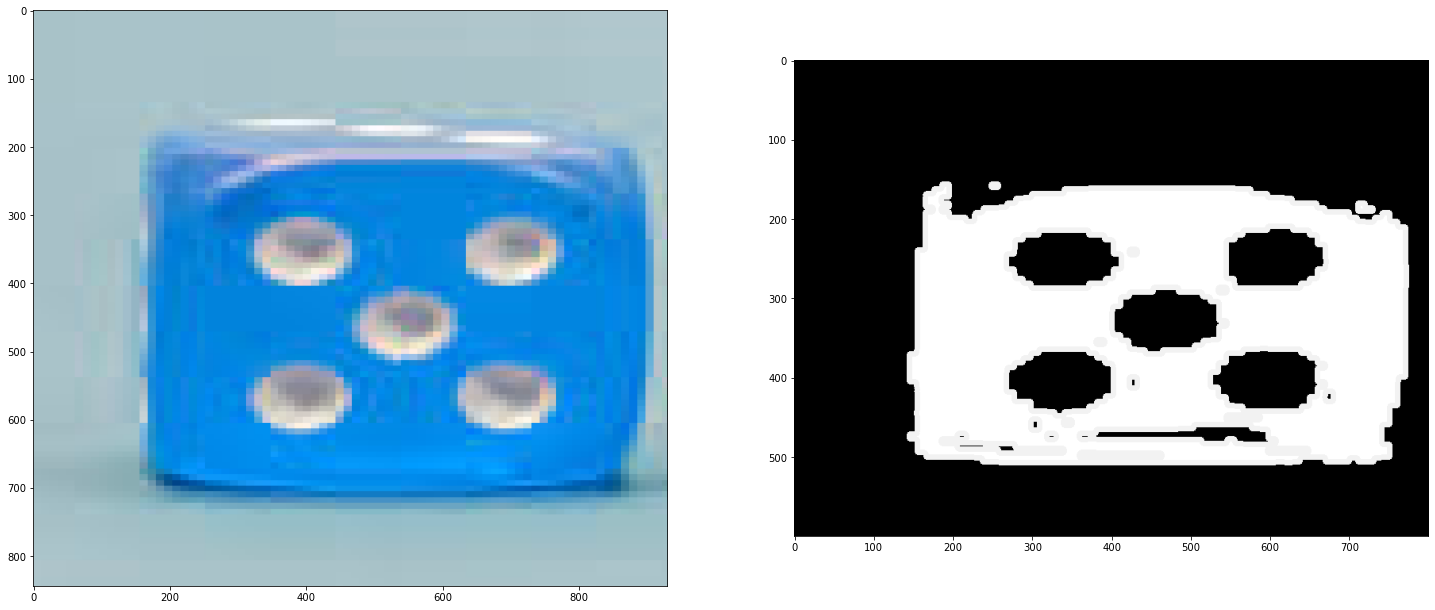

In [572]:
image1 = cv.imread("kostka.png")
contour = process_image(image1)

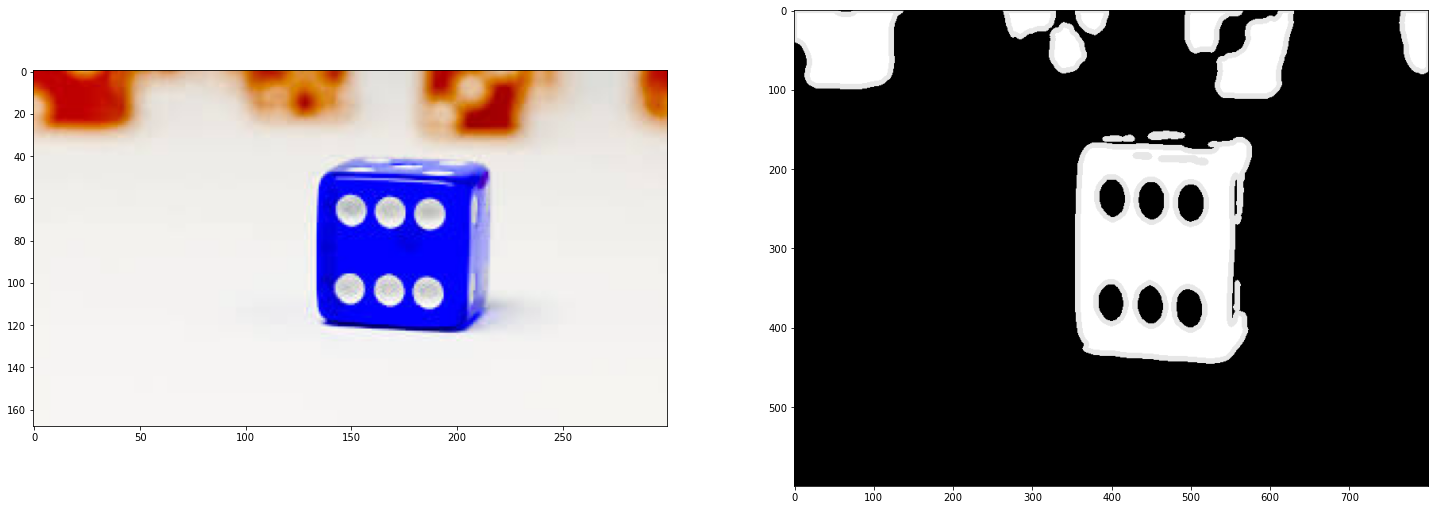

In [573]:
image1 = cv.imread("dicee.jpg")
contour = process_image(image1)

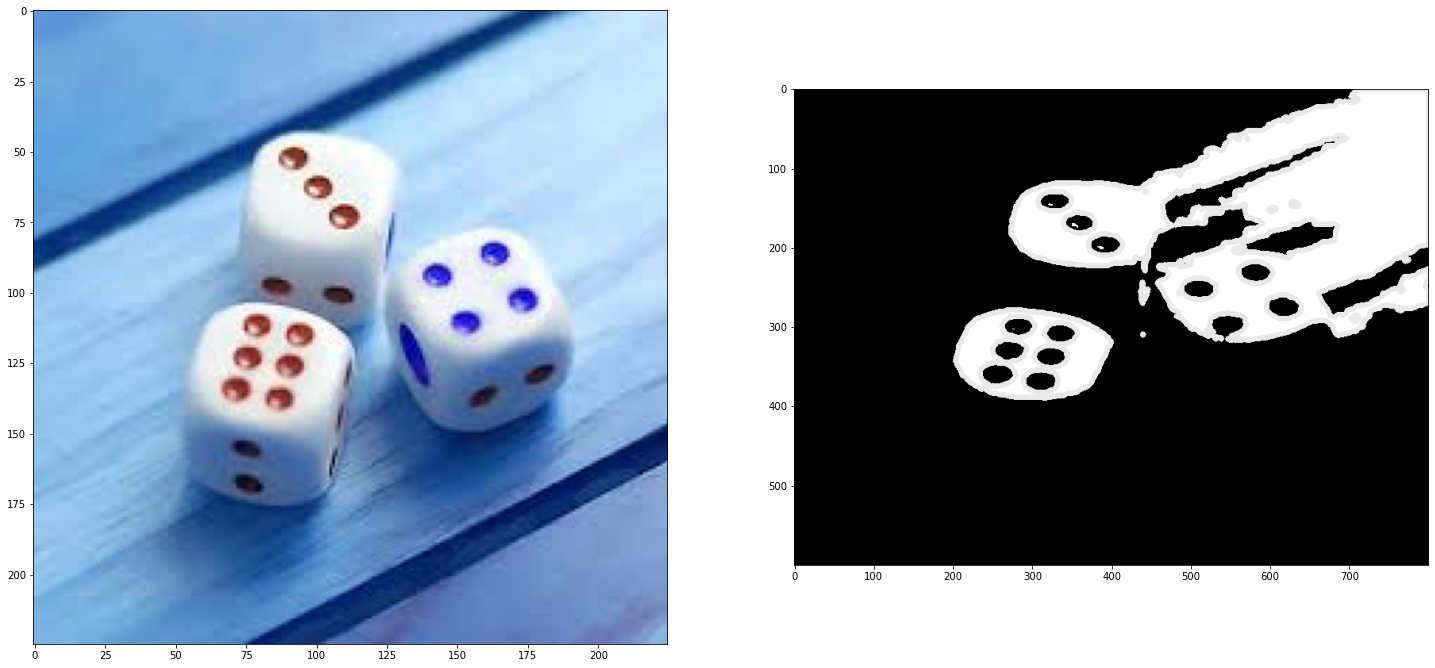

In [574]:
image1 = cv.imread("images.png")
contour = process_image(255-image1)

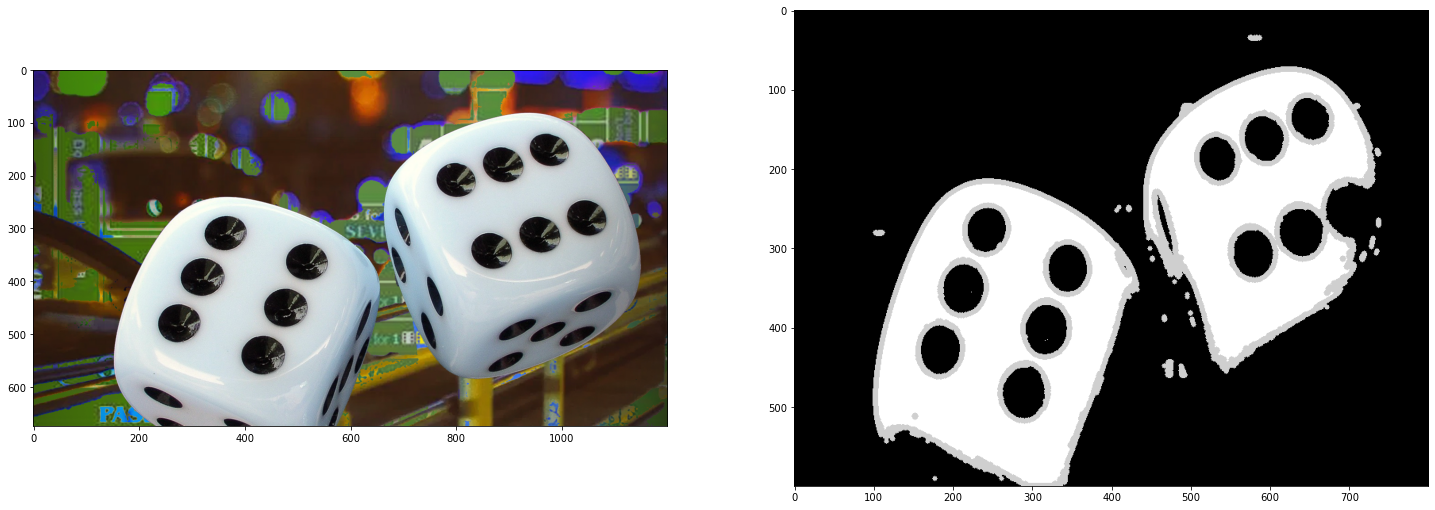

In [575]:
image1 = cv.imread("dice_back.jpg")
contour = process_image(255-image1)